In [2]:
import pandas as pd
import torch 
import numpy as np
from d2l import torch as d2l
from torch import nn


读取数据

In [3]:
train_data = pd.read_csv("D:/Develop/workspace/data/kaggle_house_pred_train.csv")
test_data = pd.read_csv("D:/Develop/workspace/data/kaggle_house_pred_test.csv")
print(train_data.dtypes)
print(test_data.dtypes)
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
print(all_features.shape)
print(all_features.iloc[0:4,[0,1,2,3,4]])

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object
(2919, 79)
   MSSubClass MSZoning  LotFrontage  LotArea Street
0          60       RL         65.0     8450   Pave
1          20       RL         80.0     9600   Pave
2          60       RL         68.0    11250   Pave
3          70       RL         60.0     9550   Pave


数据预处理

In [3]:
num_index  =all_features.dtypes[all_features.dtypes != 'object'].index   #将所有的数值类数据标准化
all_features[num_index] = all_features[num_index].apply(lambda x: (x - x.mean())/x.std())
all_features[num_index] = all_features[num_index].fillna(0)

print(all_features.dtypes)
all_features = pd.get_dummies(all_features, dummy_na=True)   #将所有非数值类型变为编号
print(all_features.shape)
print(all_features.dtypes)

MSSubClass       float64
MSZoning          object
LotFrontage      float64
LotArea          float64
Street            object
                  ...   
MiscVal          float64
MoSold           float64
YrSold           float64
SaleType          object
SaleCondition     object
Length: 79, dtype: object
(2919, 331)
MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca       uint8
SaleCondition_Family       uint8
SaleCondition_Normal       uint8
SaleCondition_Partial      uint8
SaleCondition_nan          uint8
Length: 331, dtype: object


In [11]:
train_features = torch.tensor(all_features[:train_data.shape[0]].values, dtype=torch.float32)   #提取训练集和测试集
test_features = torch.tensor(all_features[train_data.shape[0]:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [17]:
loss  = nn.MSELoss()
input_dim = train_features.shape[1]
def get_net():
    return nn.Sequential(nn.Linear(input_dim,1))

# 这里我们比较关心的是预测误差的百分比，这里可以用log(pre) - log(y)的均方误差来代替
def log_rmse(net,features,train_labels):
    clipped_predic = torch.clamp(net(features),1,float("inf"))
    rmse = torch.sqrt(loss(torch.log(clipped_predic),torch.log(train_labels)))
    
    return rmse

In [18]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [19]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [26]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

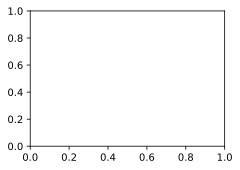

In [27]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')